In [1]:
import pandas as pd
import numpy as np
from pygobnilp.gobnilp import Gobnilp
import pgmpy
import itertools
from pgmpy.estimators.CITests import pearsonr
from pgmpy.estimators.CITests import chi_square
import networkx as nx
import time
import collections

In [2]:
def csv_format_discrete(csv_file):
    df = pd.read_csv(csv_file, sep="\s+")
    return df.drop([0])

#returns the csv_file in a pandas dataframe, formatted properly, discrete dataset only

In [3]:
#small network : n <= 20 nodes, medium network: 20 <= n <= 50 , large: 50 <= n <= 100, ... 
df_small = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\asia_10000.dat")
df_medium = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat")
df_alarm100 = csv_format_discrete(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_100.dat")
# df_large = csv_format_discrete(r"")

### chi-squared test

In [4]:
df_small

,One,Two,Three,Four,Five,Six,Seven,Eight
1,1,1,0,0,0,1,0,1
2,1,0,0,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,1,0,1,0,0,0,1,0
5,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
9996,0,0,1,0,0,0,0,0
9997,1,0,1,0,0,0,1,1
9998,0,0,0,0,0,0,1,0
9999,1,0,0,0,0,0,1,0


In [5]:
#0th order chi2 test
def chi2bool(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    chi2 = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        chi = chi_square(X=i, Y=j, Z=[], data=df, significance_level=rho)
        chi2.append((i,j,chi))
    true_0 = [x for x in chi2 if True in x]
    false_0 = [x for x in chi2 if False in x]
    return true_0, false_0

### Pearson's Product Moment Correlation Coefficient

In [6]:
df_gaus = pd.read_csv(r"C:\Users\User\Documents\GitHub\ML_FYP\dataset\gaussian.dat", sep="\s+")
df_gaus

,A,B,C,D,E,F,G
0,1.113083,1.932164,7.074806,8.660411,0.881591,24.719501,9.216382
1,-0.247948,11.334343,24.347372,23.355432,7.040113,36.812996,3.678833
2,1.854508,3.032020,11.086473,11.055891,3.834530,22.017182,2.424513
3,0.833911,3.857970,11.224775,11.937471,1.005624,23.285643,6.085473
4,0.488614,4.512613,10.000476,12.537179,4.084746,24.537596,5.117575
...,...,...,...,...,...,...,...
4995,0.625860,1.587941,5.952431,8.516822,4.894385,16.950123,2.558535
4996,0.241723,-0.497071,1.695681,5.563204,7.454081,21.165266,4.867241
4997,2.527720,-2.706339,0.984988,1.597447,3.692427,18.808892,5.598200
4998,1.484585,1.468603,7.206672,8.486116,2.611856,21.528922,5.106188


In [7]:
#0th order chi2 test
def PMCC(df, rho):
    '''
    0th order CI test
    
    Parameters:
    df -> pandas dataframe
    rho -> significance level, only accept 0 <= rho <= 1.0
    '''
    R_list = []
    v = list(df)
    my_list = list(itertools.combinations(v,2))
    y_0, y_1 = [x[0] for x in my_list], [x[1] for x in my_list]
    for i,j in zip(y_0, y_1):
        R = pearsonr(X=i, Y=j, Z=[], data=df, significance_level=rho)
        R_list.append((i,j,R))
    true_0 = [x for x in R_list if True in x]
    false_0 = [x for x in R_list if False in x]
    return true_0, false_0

### Sorting Functions

In [8]:
def create_permutations(my_list):
    '''
    takes in a list, remove extra permutations from the list and only creates a pair of permutations
    '''
    p_permutations = []
    new_list = list(set(tuple(sorted(l[:2])) for l in my_list))
    for items in new_list:
        new_list_0 = list(itertools.permutations(items[:2],2))[1]
        p_permutations.append(new_list_0)
    return new_list + p_permutations

In [9]:
#given 2 lists, append them together and remove duplicates
def remove_permutations(list_):
    '''
    returns a sorted list without permutation
    '''
    return sorted(list(set(tuple(sorted(l[:2])) for l in list_)))

In [10]:
def PC_(df, n, rho):
    '''
    Note:
    This function will start from at least 0th order CI
    
    Parameters:
    df (pandas dataframe)
    n an integer, the stopping point of the while loop
    rho (the significance level, only accepts values between 0 and 1 inclusive)
    
    Returns:
    A list which contains every independent X and Y
    '''
    N = 3
    v = list(df)
    # remove_list = [x for x in p_permute]
    remove_list = create_permutations([x[:2] for x in chi2bool(df, rho)[0]])
    #x[:2] for 0th order and its permutations, so we can later remove it 
    empty_list = []
    while N <= n:
        list_permutations = [x for x in itertools.permutations(v, N) if x[:2] not in remove_list]
        p_1, p_2, p_3 = [x[:1] for x in list_permutations], [x[1:2] for x in list_permutations], [x[2:] for x in list_permutations]
        for i,j,k in zip(p_1, p_2, p_3):
            chi2 = chi_square(X=i[0], Y=j[0], Z=k, data=df, significance_level=rho)
            empty_list.append((i[0],j[0],k,chi2))
        true_list = create_permutations([x[:2] for x in empty_list if True in x])
        #create_permutations ensures only 1 set of permutations of (X,Y) and (Y,X) and removes dupes
        remove_list = remove_list + create_permutations(true_list)
        remove_list = create_permutations(remove_list)
        N += 1
        
    return remove_permutations(remove_list) #returns 1 set of permutations

#ON MEDIUM SIZED NETWORKS:
#1st order CI takes 2minutes to run
#2nd order CI 9-15minutes to run
#nP5 takes ??? minutes to run
#nP6 not doable

### graph

In [11]:
def Graph(df):
    G = nx.Graph()
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
#     print(G)
    return(G)

Graph with 37 nodes and 666 edges


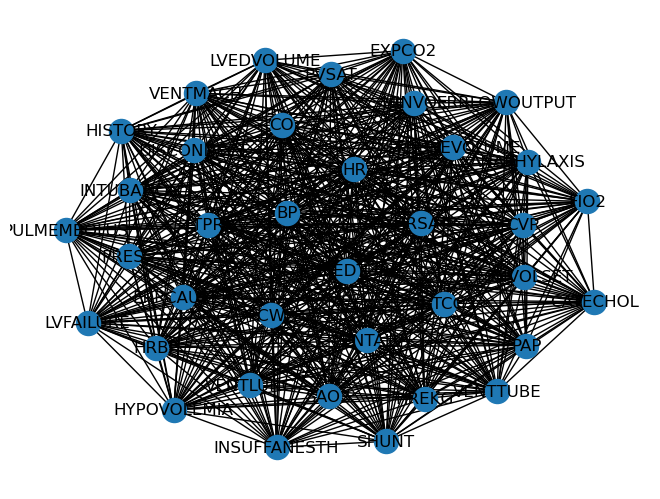

In [12]:
g = Graph(df_medium)
print(g)
nx.draw(g, with_labels = True)

In [13]:
def PC_0(df, rho, G):
    '''
    finds 0th order conditional independencies (CI) between each node, if True then remove an edge 
    '''
    v = list(df)
    for i in v:
        G.add_node(i)
    k = list(itertools.combinations(v,2))
    for i,j in k:
        G.add_edge(i,j)
    ind_0 = [x[:2] for x in chi2bool(df, rho)[0]]
    for i,j in ind_0:
        G.remove_edge(i,j)
#     print(G)
    return(G, ind_0)

Graph with 37 nodes and 265 edges
CPU times: total: 1.14 s
Wall time: 1.15 s


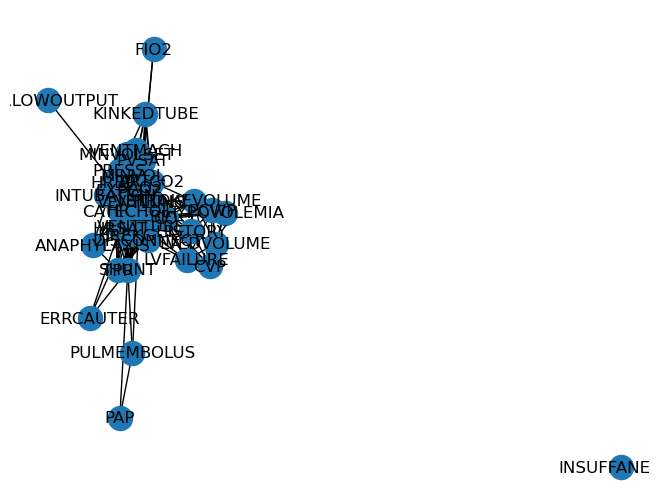

In [14]:
%%time
g_0 = PC_0(df_medium, 0.05, g)[0]
print(g_0)
nx.draw(g_0, with_labels = True)

### adjacency finder

In [15]:
def find_adjacency_XY(graph):    
    test_list = []
    graph_list = list(graph.edges)
    for i,j in graph_list:
        test_list.append((i, j, list(graph.edges(i)), list(graph.edges(j))))
    n = 0
    N = len(test_list)
    edge_XY = []
    while n < N:
        ##
        adjacent_X = []
        adjacent_Y = []
        X, Y = test_list[n][0], test_list[n][1]
        k_X, k_Y = test_list[n][2], test_list[n][3]
        edge_X = [x for x in k_X if x[1] != Y]
        edge_Y = [x for x in k_Y if x[1] not in (y[1] for y in k_X) and x[1] != X]
        for x in edge_X:
            adjacent_X.append(x[1])
        for y in edge_Y:
            adjacent_Y.append(y[1])
        adjacent_XY = adjacent_X + adjacent_Y
        len_XY = len(adjacent_XY)
        edge_XY.append((X, Y, adjacent_XY, len_XY))
#         print(edge_XY)
        n += 1
    return edge_XY

In [16]:
adj = find_adjacency_XY(g_0)

### obtaining combinations and data preprocessing

In [17]:
adj[1][0], adj[1][2][1], adj[1][2][0]

('PULMEMBOLUS', 'SAO2', 'PAP')

In [18]:
def get_combinations(this_list, N_0, rho):
    '''
    probably the main function of everything
    given a list in the form
    '''
    adjacency = this_list[2]
    len_adjacency = len(adjacency)
    n = 1
    combinations = []
    while n <= N_0:
        k = list(itertools.combinations(adjacency, n))
        t = list(list(x) for x in k)
        for i in t:
            chi2 = chi_square(X=this_list[0], Y=this_list[1], Z=i, data=df_medium, significance_level=rho)
            if chi2 == True:
                combinations.append((this_list[0], this_list[1], i, chi2))
                return combinations
        n += 1

In [19]:
def combinations_adjacents(adj, N, rho):
    '''
    one of the main functions
    adj = output from find_adjacency_XY
    N = stopping point for how many combinations you want
    output: obtains the combinations of n=1,2,...N of the whole list in an unordered manner (see open_list)
    '''
    len_adjacents = len(adj)
    combinations = []
    for i in range(len_adjacents):
        t = get_combinations(adj[i], N, rho)
        combinations.append(t)
    return combinations

In [20]:
def open_list(lists):
    '''
    5/4 update: this function has become kind of redundant, do not use 
    lists = output from combinations_adjacents, the whole thing
    all this function does is concatenates the adjacents of different combinations together
    '''
    n = 0
    N = len(lists)
    output = []
    while n < N:
        t = list(itertools.chain.from_iterable(lists[n][2]))
        output.append((lists[n][0], lists[n][1], t))
        n += 1
    return output

### chi2 test 

In [21]:
def chi2_list(this_list, df, rho):
    '''
    update 5/4, this function has become kind of redundant as well
    performs chi2 test on 1 list in open_list format
    '''
    n = 0
    N = len(this_list[2])
    x = this_list[0]
    y = this_list[1]
    output = []
    while n < N:
        chi2 = chi_square(X=x, Y=y, Z=this_list[2][n], data=df, significance_level=rho)
        if chi2 == True:
            output.append(chi2)
            break
        n += 1
    return output

In [22]:
def PC_final(graph, adj, N, df, rho):
    '''
    graph = nx.graph
    adj = output from find_adjacency_XY
    N = order of conditional independence
    df = dataframe
    rho = significance_level
    '''
    X_Y = []
    combinations_chi2 = combinations_adjacents(adj, N, rho)
    for i in combinations_chi2:
        if i != None:
            for j in i:
                X_Y.append((j[0], j[1]))
    for i in X_Y:
        graph.remove_edge(i[0], i[1])
    return graph, X_Y

Graph with 37 nodes and 265 edges
[('PULMEMBOLUS', 'PAP'), ('PULMEMBOLUS', 'SHUNT'), ('PULMEMBOLUS', 'SAO2'), ('PAP', 'SHUNT'), ('KINKEDTUBE', 'VENTLUNG'), ('KINKEDTUBE', 'VENTALV'), ('KINKEDTUBE', 'PVSAT'), ('KINKEDTUBE', 'SAO2'), ('KINKEDTUBE', 'ARTCO2'), ('KINKEDTUBE', 'EXPCO2'), ('KINKEDTUBE', 'PRESS'), ('KINKEDTUBE', 'MINVOL'), ('INTUBATION', 'VENTLUNG'), ('INTUBATION', 'SHUNT'), ('INTUBATION', 'VENTALV'), ('INTUBATION', 'PVSAT'), ('INTUBATION', 'SAO2'), ('INTUBATION', 'ARTCO2'), ('INTUBATION', 'CATECHOL'), ('INTUBATION', 'HR'), ('INTUBATION', 'HREKG'), ('INTUBATION', 'EXPCO2'), ('INTUBATION', 'PRESS'), ('INTUBATION', 'MINVOL'), ('INTUBATION', 'HRSAT'), ('MINVOLSET', 'VENTMACH'), ('MINVOLSET', 'VENTTUBE'), ('MINVOLSET', 'VENTLUNG'), ('MINVOLSET', 'VENTALV'), ('MINVOLSET', 'PVSAT'), ('MINVOLSET', 'SAO2'), ('MINVOLSET', 'ARTCO2'), ('MINVOLSET', 'CATECHOL'), ('MINVOLSET', 'HR'), ('MINVOLSET', 'HREKG'), ('MINVOLSET', 'CO'), ('MINVOLSET', 'BP'), ('MINVOLSET', 'EXPCO2'), ('MINVOLSET', '

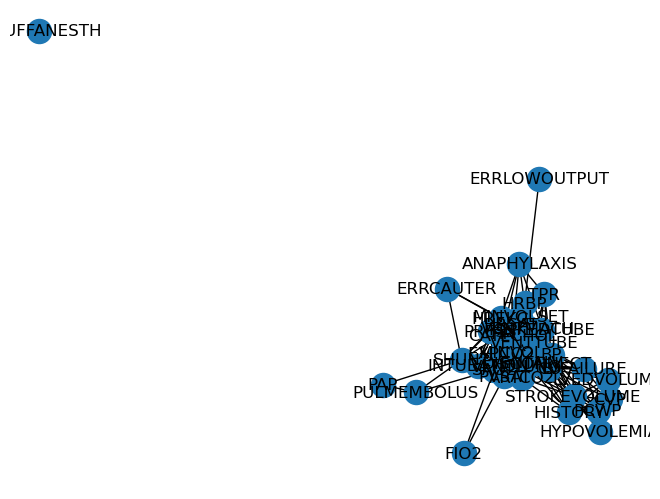

In [23]:
g = Graph(df_medium)
g_0 = PC_0(df_medium, 0.05, g)[0]
print(g_0)
print(g_0.edges())
nx.draw(g_0, with_labels=True)

Graph with 37 nodes and 73 edges
CPU times: total: 16.4 s
Wall time: 16.4 s


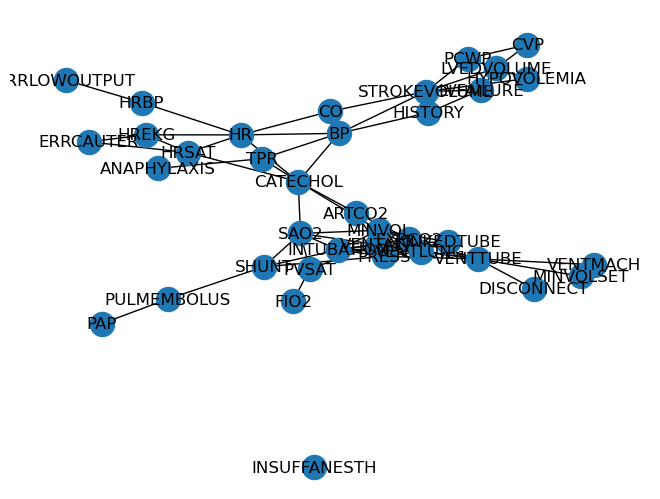

In [24]:
%%time
g_final = PC_final(g_0, adj, 1, df_medium, 0.05)[0]
print(g_final)
nx.draw(g_final, with_labels=True)

In [32]:
%%time
ind = PC_0(df_medium, 0.50, g_0)[1] + PC_final(g_0, adj, 1, df_medium, 0.50)[1]

CPU times: total: 31 s
Wall time: 31 s


In [33]:
ind

[('PULMEMBOLUS', 'KINKEDTUBE'),
 ('PULMEMBOLUS', 'MINVOLSET'),
 ('PULMEMBOLUS', 'VENTTUBE'),
 ('PULMEMBOLUS', 'FIO2'),
 ('PULMEMBOLUS', 'ARTCO2'),
 ('PULMEMBOLUS', 'ANAPHYLAXIS'),
 ('PULMEMBOLUS', 'CATECHOL'),
 ('PULMEMBOLUS', 'HR'),
 ('PULMEMBOLUS', 'LVFAILURE'),
 ('PULMEMBOLUS', 'LVEDVOLUME'),
 ('PULMEMBOLUS', 'CVP'),
 ('PULMEMBOLUS', 'CO'),
 ('PULMEMBOLUS', 'EXPCO2'),
 ('PULMEMBOLUS', 'PRESS'),
 ('PULMEMBOLUS', 'HISTORY'),
 ('PULMEMBOLUS', 'PCWP'),
 ('PAP', 'KINKEDTUBE'),
 ('PAP', 'VENTMACH'),
 ('PAP', 'DISCONNECT'),
 ('PAP', 'VENTLUNG'),
 ('PAP', 'PVSAT'),
 ('PAP', 'SAO2'),
 ('PAP', 'ANAPHYLAXIS'),
 ('PAP', 'TPR'),
 ('PAP', 'ERRCAUTER'),
 ('PAP', 'HYPOVOLEMIA'),
 ('PAP', 'LVFAILURE'),
 ('PAP', 'LVEDVOLUME'),
 ('PAP', 'CVP'),
 ('PAP', 'STROKEVOLUME'),
 ('PAP', 'BP'),
 ('PAP', 'EXPCO2'),
 ('PAP', 'ERRLOWOUTPUT'),
 ('PAP', 'PRESS'),
 ('PAP', 'HISTORY'),
 ('PAP', 'HRSAT'),
 ('PAP', 'PCWP'),
 ('KINKEDTUBE', 'MINVOLSET'),
 ('KINKEDTUBE', 'VENTMACH'),
 ('KINKEDTUBE', 'DISCONNECT'),
 ('KIN

### test network

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-21
Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<-TPR -471.4855693726131
TPR<- -10901.914716929197
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
CO<-HR,STROKEVOLUME -2678.9117199075117
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KIN

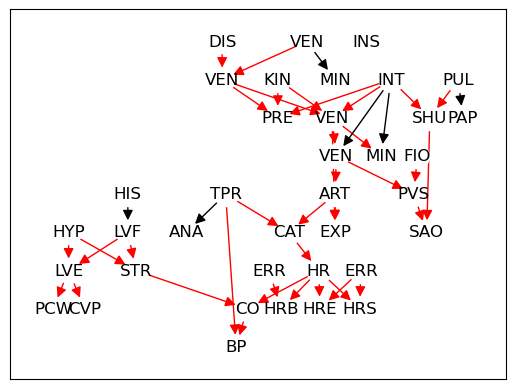

CPU times: total: 4.73 s
Wall time: 3.79 s


In [26]:
%%time
k = Gobnilp()
for i,j in ind:
    k.add_forbidden_adjacency((i,j))
k.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat', palim = 4)

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<-TPR -471.4855693726131
TPR<- -10901.914716929197
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
CO<-HR,STROKEVOLUME -2678.9117199075117
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<- -2091.776919943207

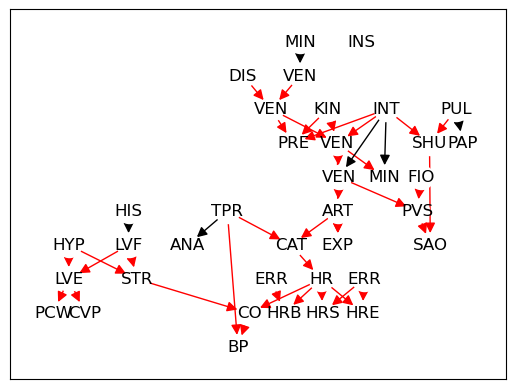

CPU times: total: 22min 55s
Wall time: 7min 35s


In [27]:
%%time
m = Gobnilp()
m.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat', palim=4)

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<- -578.587070487134
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
TPR<-ANAPHYLAXIS -10794.813215814676
CO<-HR,STROKEVOLUME -2678.9117199075117
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<-LVFAILURE -6

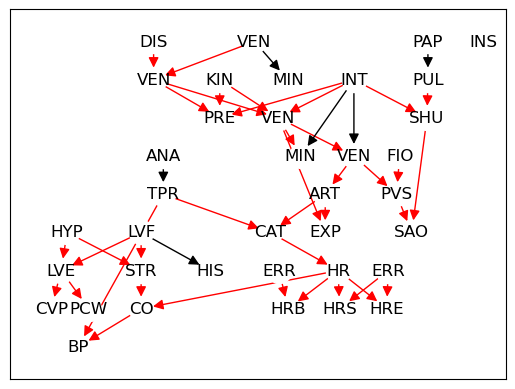

CPU times: total: 8min 51s
Wall time: 2min 53s


In [28]:
%%time
s = Gobnilp()
s.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat')

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<- -578.587070487134
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
TPR<-ANAPHYLAXIS -10794.813215814676
CO<-HR,STROKEVOLUME -2678.9117199075117
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<- -2091.77691

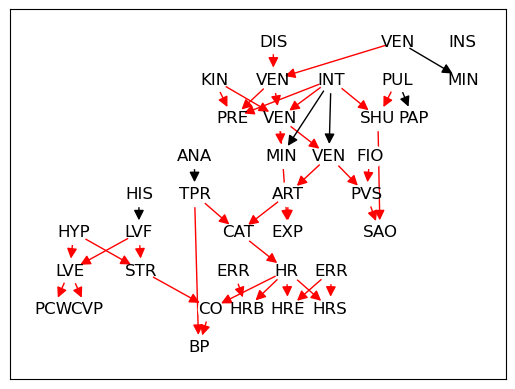

CPU times: total: 5.27 s
Wall time: 3.77 s


In [29]:
%%time
w = Gobnilp()
for i,j in ind:
    w.add_forbidden_adjacency((i,j))
w.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat')

Set parameter PreCrush to value 1
Set parameter CutPasses to value 100000
Set parameter GomoryPasses to value 100000
Set parameter MIPFocus to value 2
Set parameter ZeroHalfCuts to value 2
Set parameter MIPGap to value 0
Set parameter MIPGapAbs to value 0
**********
BN has score -105226.51191678003
**********
ANAPHYLAXIS<- -578.587070487134
ARTCO2<-VENTALV -1816.018107669981
VENTALV<-INTUBATION,VENTLUNG -1785.1568955858384
BP<-CO,TPR -4927.804606748883
TPR<-ANAPHYLAXIS -10794.813215814676
CO<-HR,STROKEVOLUME -2678.9117199075117
CATECHOL<-ARTCO2,TPR -1521.301873422577
HR<-CATECHOL -3744.599767304855
STROKEVOLUME<-HYPOVOLEMIA,LVFAILURE -4437.288938131547
CVP<-LVEDVOLUME -3006.615302132195
LVEDVOLUME<-HYPOVOLEMIA,LVFAILURE -3613.5057310384145
DISCONNECT<- -3295.031743080661
ERRCAUTER<- -3222.5768222310726
ERRLOWOUTPUT<- -1972.2788189759885
EXPCO2<-ARTCO2,VENTLUNG -1772.659127224848
VENTLUNG<-INTUBATION,KINKEDTUBE,VENTTUBE -3618.0085247885727
FIO2<- -1888.628670533668
HISTORY<- -2091.77691

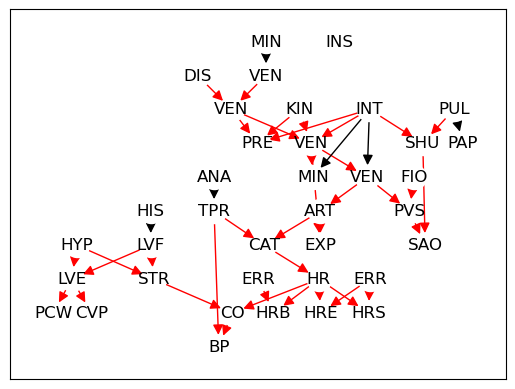

CPU times: total: 5.48 s
Wall time: 3.81 s


In [31]:
%%time
k1 = Gobnilp()
for i,j in ind:
    k1.add_forbidden_adjacency((i,j))
k1.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat', palim = None)

In [ ]:
%%time
k_2 = Gobnilp()
for i,j in ind:
    k_2.add_forbidden_adjacency((i,j))
k_2.learn(r'C:\Users\User\Documents\GitHub\ML_FYP\dataset\alarm_10000.dat', palim = 6)